# Setup

In [94]:
import math
import pandas as pd
import numpy as np
import numpy
import random
import decimal
import scipy.linalg
import numpy.random as nrand
import matplotlib.pyplot as plt
from function import *
from datetime import datetime, timedelta
import mplfinance as mpl 
class ModelParameters:
    def __init__(self,
                 all_s0, all_time, all_delta, all_sigma, gbm_mu,
                 jumps_lamda=0.0, jumps_sigma=0.0, jumps_mu=0.0, all_r0 = 0):
        # This is the starting asset value
        self.all_s0 = all_s0
        # How long you want to stimulate
        self.all_time = all_time
        # This is the delta, the rate of time e.g. 1/252 = daily, 1/12 = monthly
        self.all_delta = all_delta
        # This is the volatility of the stochastic processes
        self.all_sigma = all_sigma
        # This is the annual drift factor for geometric brownian motion
        self.gbm_mu = gbm_mu
        # This is the probability of a jump happening at each point in time
        self.lamda = jumps_lamda
        # This is the volatility of the jump size
        self.jumps_sigma = jumps_sigma
        # This is the average jump size
        self.jumps_mu = jumps_mu
        # This is the starting interest rate value
        self.all_r0 = all_r0


# Model

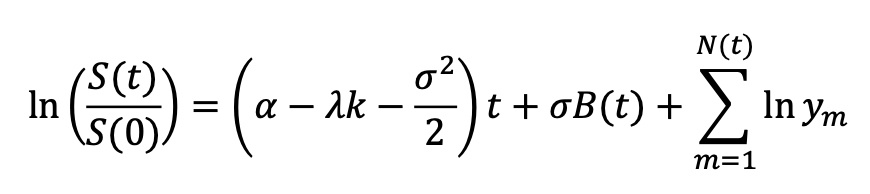

In [95]:
from IPython import display
display.Image("./equation.png")

# Parameter Calculation

In [96]:
# options = "DU, EAND, EMAAR, ENBD, FAB, IHC, TAQA"
company = 'EAND'

# Getting the price data (last 10 years of data)
df = pd.read_csv(f'CSVs/{company}.csv')

# Adding a column for Jump
df['differance'] = np.log(df['Price']/ df['Price'].shift(-1))
SD_stock = np.std(df['differance'])
Mean_stock = np.mean(df['differance'])
daily_returns = (df['differance'][1:]).tolist()
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,differance
0,05/05/2023,23.40,23.40,23.52,23.24,606.93K,-0.34%,-0.003413
1,05/04/2023,23.48,23.30,23.58,23.30,947.70K,1.12%,0.011135
2,05/03/2023,23.22,23.22,23.60,23.16,2.28M,0.09%,0.000862
3,05/01/2023,23.20,24.02,24.02,23.20,1.09M,-3.33%,-0.033902
4,04/28/2023,24.00,24.20,24.48,24.00,1.42M,-0.83%,-0.008299


### Calculating Jump size and Frequency

In [97]:
# Getting jump size while setting 1 percentile price move and 99 percentile + price move as jumps

jumps = [returns for returns in daily_returns if np.abs(returns - Mean_stock) > 1.96 *SD_stock]
jumps.sort()

jumps_Reg = [round(np.exp(i)-1, 4) for i in jumps]
print("5 largest positive single day moves ", list(reversed(jumps_Reg[-5:])))
print("5 largest negative single day moves", jumps_Reg[:5])

# Probability of jump is simple num_of_jump/total_observation 
prob_of_jump = len(jumps)/len(df)
print("The probability of jump is", round(prob_of_jump, 3), "%")

5 largest positive single day moves  [0.15, 0.1492, 0.1486, 0.1, 0.0906]
5 largest negative single day moves [-0.0989, -0.0986, -0.0884, -0.0709, -0.0707]
The probability of jump is 0.051 %


### Setting Parameters

In [98]:
# S0 is simply the last stock price
S0 = df.loc[0, 'Price']

#number of days
time_to_maturity = 252

# average price movement
drift = np.mean(df['differance'])*np.sqrt(252)

# non jump price movement SD
non_jumps = [returns for returns in daily_returns if np.abs(returns - Mean_stock) < 1.96 *SD_stock]
gbm_sd = np.std(non_jumps)*np.sqrt(252)

# risk_free rate, using US T-bill since Dhiram is pegged to USD
rf = 0.0459

# mean of the jumps
mean_jump_size = np.mean(jumps)

# SD of Jumps
SD_of_jump = np.std(jumps)


# Running Simulation

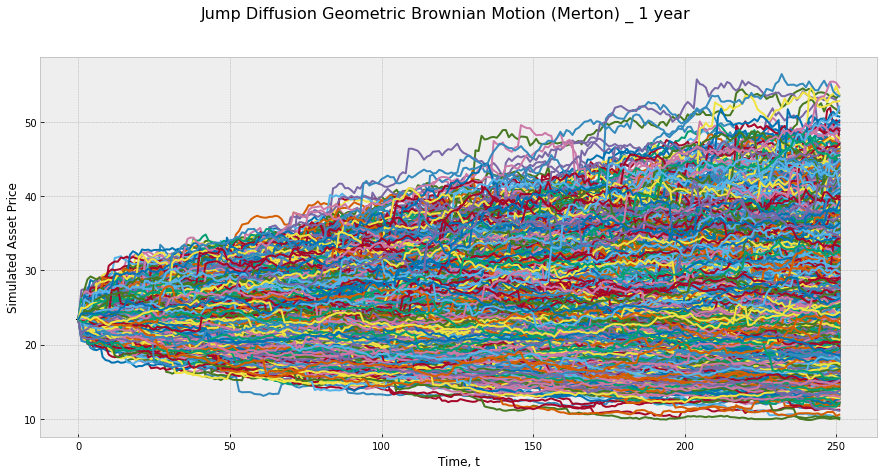

In [99]:
mp = ModelParameters(
        # This is the starting asset value
        all_s0 = S0, 
    
        # How long you want to stimulate
        all_time = time_to_maturity,
    
        # This is the delta, the rate of time e.g. 1/252 = daily, 1/12 = monthly
        all_delta = 1/252,
    
        # This is the volatility of the stochastic processes
        all_sigma = gbm_sd,
    
        # This is the annual drift factor for geometric brownian motion
        gbm_mu = drift,
    
        # This is the probability of a jump happening at each point in time
        jumps_lamda = prob_of_jump,
    
        # This is the volatility of the jump size
        jumps_sigma = SD_of_jump,
    
        # This is the average jump size
        jumps_mu = mean_jump_size,
    
        # This is the starting interest rate value
        all_r0 = rf)
paths = 10000
jump_diffusion_examples = []
for i in range(paths):
    jump_diffusion_examples.append(geometric_brownian_motion_jump_diffusion_levels(mp))
plot_stochastic_processes(jump_diffusion_examples, "Jump Diffusion Geometric Brownian Motion (Merton) _ 1 year")

# Getting the price distrbution

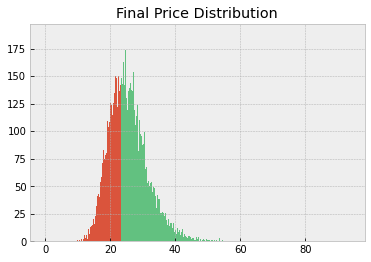

In [106]:
# Getting the price distrbution
final_prices = []
for _, price in enumerate(jump_diffusion_examples):
    final_prices.append(price[-1])
fig, ax = plt.subplots()
n, bins, patches = ax.hist(final_prices, bins=450, range=[0, S0*4], color='gray')
for i, patch in enumerate(patches):
    if bins[i] <= S0:
        patch.set_fc('#DA543C')
    else:
        patch.set_fc('#62C180')
plt.title("Final Price Distribution")
plt.show()


# Calculating Option price

In [103]:
strike_price = 21

# Calculating payoff for each path
pay_off_for_call_each_path = [max(price - strike_price, 0) for price in final_prices]
pay_off_for_put_each_path =  [max(strike_price - price, 0) for price in final_prices]

# Calculating average pay off
average_pay_off_call = np.mean(pay_off_for_call_each_path)
average_pay_off_put = np.mean(pay_off_for_put_each_path)

# Finding the present value of the options
pv_of_call = np.exp(-time_to_maturity/252*rf)*average_pay_off_call
pv_of_put = np.exp(-time_to_maturity/252*rf)*average_pay_off_put
print("The present value of the european call option with strike price AED",strike_price, " expiring in", time_to_maturity, "days is AED"
     ,round(pv_of_call, 3) ,"\nThe present value of european put option with same strike and maturity is AED", round(pv_of_put, 3))

The present value of the european call option with strike price AED 21  expiring in 252 days is AED 4.88 
The present value of european put option with same strike and maturity is AED 0.543


# Finding Price as function of Strike

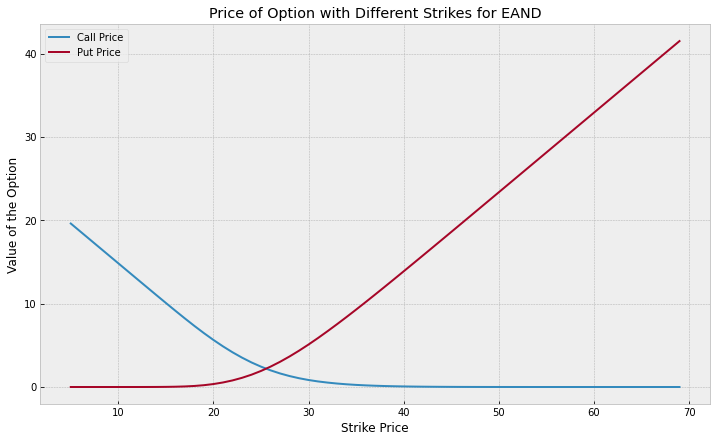

In [102]:
strikes = [i for i in range(int(S0*0.25), int(S0*3))]
call_prices = []
put_prices = []

for _, K in enumerate(strikes):
    pay_off_for_call_each_path = [max(price - K, 0) for price in final_prices]
    pay_off_for_put_each_path =  [max(K - price, 0) for price in final_prices]
    
    average_pay_off_call = np.mean(pay_off_for_call_each_path)
    average_pay_off_put = np.mean(pay_off_for_put_each_path)
    
    pv_of_call = np.exp(-time_to_maturity/252*rf)*average_pay_off_call
    pv_of_put = np.exp(-time_to_maturity/252*rf)*average_pay_off_put
    call_prices.append(pv_of_call)
    put_prices.append(pv_of_put)
fig = plt.figure(figsize=(12, 7))
plt.plot(strikes, call_prices, label='Call Price')
plt.plot(strikes, put_prices, label='Put Price')

plt.xlabel('Strike Price')
plt.ylabel('Value of the Option')
plt.title(f'Price of Option with Different Strikes for {company}')
plt.legend()

plt.show()
